# Moana Project model data examples: loading and plotting in python

Note: The Moana Backbone files are quite large (~20GB per processed_3D file).  This notebook gives an idea of how to open these files and plot them, but to cover large time ranges, it is recommended that you use a tool like NCO or CDO to concatenate and subset files, as the methods below can be slow.

Keep in mind these are just some examples to get you started.  There are many ways to access and use these data not covered here.

Files are obtained from:  http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/processed_3D/catalog.html

Please see the Moana Project website for more information:  https://www.moanaproject.org/data

Notebook by Julie Jakoboski, 17 November 2020.  For any questions on this notebook, contact julie.jakoboski@metocean.co.nz.  For questions about the Moana Project hindcast or forecast data, please contact info@moanaproject.org.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import dask
import pandas as pd
import cmocean

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.mpl as cmpl

%matplotlib inline

First we open Moana Project data, either a single file, or a list of files, as an xarray dataset (http://xarray.pydata.org/en/stable/).  Xarray allows us to work with multi-dimensional data, like 4-D ocean model output.  Keep in mind when we open a dataset with xarray, it's not actually loading all the data into python.  That only happens when necessary, like when creating a plot.  Opening a single Moana Project hindcast file looks like this, using the processed_3D data:

In [15]:
# load sample Moana backbone (hindcast) model data file,
# using chunking to keep opendap from returning an error due to large file sizes

# Use this to open a single file
url = 'http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/processed_3D/nz5km20171201_00z_3D.nc'
ds = xr.open_dataset(url, chunks={'time':1})

If you need to open more than one file, you can specify the start and end dates below.  These are used with the base_url to create a list of files between the specified dates.

In [100]:
# Open Multiple Files

# To download the entire 25-year hindcast (not recommended in jupyter notebooks, it's a lot of data):
# start_date = '1993-01-01'
# end_date = '2017-12-01'

# Choose start and end date:
start_date = '2017-10-01'
end_date = '2017-12-01'

base_url = 'http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/processed_3D/nz5km%Y%m%d_00z_3D.nc'

# Create list of files to be downloaded
dates= pd.date_range(start_date, end_date, freq='1M')-pd.offsets.MonthBegin(1)
files = [day.strftime(base_url) for day in dates]

# Open list of files as single dataset as variable ds
ds = xr.open_mfdataset(files, chunks={'time':1})

Whether we loaded a single file or a list of files, the result in a single dataset.  We can take a look at that dataset to see what the variable names and dimensions are, along with any other metadata included in the netcdf file:

In [101]:
ds

<xarray.Dataset>
Dimensions:  (lat: 467, lev: 28, lon: 397, time: 490)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-01 2017-10-01T03:00:00 ... 2017-12-01
  * lev      (lev) int32 0 5 10 15 20 25 30 ... 2000 2500 3000 4000 5000 6000
  * lon      (lon) float64 161.0 161.1 161.2 161.2 ... 184.8 184.8 184.9 185.0
  * lat      (lat) float64 -51.98 -51.94 -51.91 -51.87 ... -31.13 -31.08 -31.03
Data variables:
    dep      (time, lat, lon) float32 dask.array<chunksize=(249, 467, 397), meta=np.ndarray>
    u        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 28, 467, 397), meta=np.ndarray>
    v        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 28, 467, 397), meta=np.ndarray>
    temp     (time, lev, lat, lon) float32 dask.array<chunksize=(1, 28, 467, 397), meta=np.ndarray>
    salt     (time, lev, lat, lon) float32 dask.array<chunksize=(1, 28, 467, 397), meta=np.ndarray>
Attributes:
    type:                      MSL ROMS 3D output file
    history:                   Thu Jan 30 08:58:24 2020: ncap2 -D 2 -O -s tim...
    NCO:                       "4.5.4"
    nco_openmp_thread_number:  1

From the output of ds, we can see that the depth variable is called 'lev'.  Now that we've opened the file(s) as an xarray dataset, we can select a subset and do a plot of temperature at a chosen depth level, averaged over the entire time range that we chose above.  In this case, we will use xarray's built in plotting functions:

/home/jjakoboski/.virtualenvs/moana_notebook/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


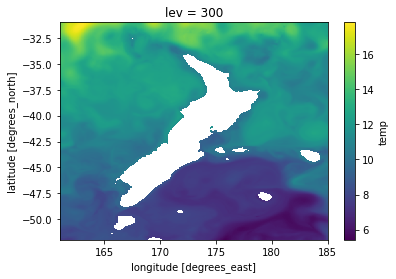

In [98]:
# create a map of temperature at a chosen depth
# choose a depth level (lev = 300 selects the 300 m depth level)
da = ds.sel(lev=300)

# calculate mean over the time dimension
time_mean_300m = da.mean(dim='time')

# plot time-mean temperature at the depth chosen above
time_mean_300m['temp'].plot.pcolormesh()

Sometimes we need fancy maps with coastline, formatted lat/lon, etc:

In [ ]:
# same as before, but this time we'll plot the 50 m depth level
da = ds.sel(lev=50)

# calculate mean over the time dimension
time_mean_50m = da.mean(dim='time')

# plot time-mean temperature at the depth chosen above, using the cartopy package
# cartopy information goes in subplot_kws dictionary
p = time_mean_50m['temp'].plot(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),transform=ccrs.PlateCarree())

# set map domain
box = [161, 185, -51.98, -31.03]  
p.axes.set_extent(box, crs=ccrs.PlateCarree())

# add coastlines and and
p.axes.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
p.axes.add_feature(land_10m)


#cbar = plt.colorbar(dot,label="Temperature ($^\circ$C)")
#plt.title('Bottom or Fishing Temperature \n {} to {}'.format(start_date,end_date))

# drawline gridlines
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
#gl.xlines = True
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 15, 'color': 'black'}
#gl.xlabel_style = {'color': 'black'}
#gl.right_labels = gl.top_labels = False

Next, we select only one lat/lon point and plot salinity as a function of time and depth.  In this plot, we change some of the default labels that xarray calculated for us and choose cmocean's haline colormap (https://matplotlib.org/cmocean/):

Text(0.5, 0, 'Date')

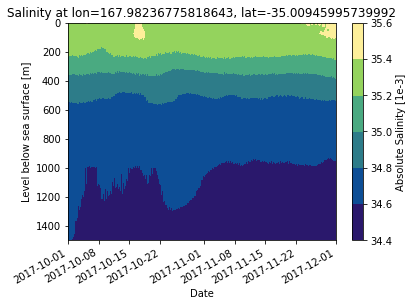

In [109]:
# Plot timeseries of salinity at all depths over time at one point
lat = -35
lon = 168

# select data only at the desired lat,lon point, drop all nan rows
one_point = ds.sel(dict(lat=lat,lon=lon),method = 'nearest').dropna(dim='lev')

# make a contourf plot of salinity as a function of time and depth, use the cmocean haline colormap
one_point['salt'].plot.contourf(x='time',y='lev', yincrease=False, cmap = cmocean.cm.haline, cbar_kwargs={"label": "Absolute Salinity [1e-3]"})
plt.title("Salinity at lon={}, lat={}".format(one_point['lon'].values,one_point['lat'].values))

# example to change x- and y-labels:
plt.xlabel('Date')

We can also plot average temperature, salinity, or current velocity depth-position section along a horizontal track, specified by an array of latitudes and an array of longitudes, corresponding to the lat/lon coordinates of the track.  In this case, we will plot a temperature section.  But in the next cell, we only select the data and save as new lat, lon, lev, and temp variables, so we can then use those variables later:

In [ ]:
# Plot a depth-distance section of time-average temperature along a track specified by lat-lon coordinates
start_lat = -32.5
end_lat = -40
start_lon = 165
end_lon = 168
num_points = 40
lat = np.linspace(start = start_lat, stop = end_lat, num = num_points)
lon = np.linspace(start = start_lon, stop = end_lon, num = num_points)

# Specify start and end times to subset
start_date = "2017-11-05"
end_date = "2017-11-10"

# To select points in xarray, need to convert lat, lon to DataArrays
lat = xr.DataArray(lat, dims="z")
lon = xr.DataArray(lon, dims="z")

# choose only the lat-lon coordinates of temperature data
section_along_track = ds.sel(lat=lat,lon=lon,method = 'nearest')

# now select on a subset of times, then take the mean over those times
sectiona_along_track = section_along_track.sel(time=slice(start_date,end_date)).mean(dim='time').dropna(dim='lev')

# generate lat, lev, temp data for plotting in next cell
# it takes a long time to generate these variables, 
# because the model files are large
lat = section_along_track['lat'].values
lon = section_along_track['lon'].values
lev = section_along_track['lev'].values
temp = section_along_track['temp'].values

Now that we've saved the variables as numpy arrays, we can plot as many times as we'd like without having to wait for them to load.  The following is an example matplotlib contour plot of average temperature along the section we specified in the previous cell:

TypeError: Input z must be 2D, not 3D

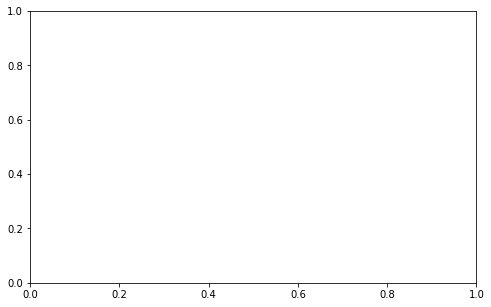

In [112]:
# instead of using xarray plot, this example we will use matplotlib alone

plt.figure(figsize=(8,5))
plt.contourf(lat,lev,temp, cmap=cmocean.cm.thermal)
cb = plt.colorbar(label='Temperature [degC]')
contours = plt.contour(lat,lev,temp,colors='black')
plt.clabel(contours, inline=True, fontsize=8, colors='black', fmt='%1.1f')

plt.title('Average Temperature Along a Section')
plt.ylim(3000,0)
plt.ylabel('Level below sea surface [m]')
plt.xlabel('Latitude along section')
plt.tight_layout()